In [60]:
import gensim
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import scale
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from imblearn.over_sampling import RandomOverSampler
from gensim.models import KeyedVectors
import seaborn as sn

# Loading Data

In [2]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_dev = pd.read_csv("dev.csv")
df.head()

,Unnamed: 0,text_a,label
0,0,betewe buka twitter cuman ngetweet liat home b...,no
1,1,mas piyuuu mugo2 corona tuh mulut tersumpal ma...,no
2,2,e100ss gini buka informasi sejelas nya identit...,yes
3,3,neng solo wes ono terduga corona cobo neng ati...,no
4,4,midiahn nii akun gak takut takut nya isu coron...,no


In [3]:
print("Train data shape:", df.shape)
print("Dev data shape:", df_dev.shape)
print("Test data shape:", df_test.shape)

Train data shape: (21601, 3)
Dev data shape: (2800, 2)
Test data shape: (2800, 2)


In [4]:
text_a = df.text_a.apply(gensim.utils.simple_preprocess)
pd.DataFrame(text_a)

,text_a
0,"[betewe, buka, twitter, cuman, ngetweet, liat,..."
1,"[mas, piyuuu, mugo, corona, tuh, mulut, tersum..."
2,"[ss, gini, buka, informasi, sejelas, nya, iden..."
3,"[neng, solo, wes, ono, terduga, corona, cobo, ..."
4,"[midiahn, nii, akun, gak, takut, takut, nya, i..."
...,...
21596,"[depok, panas, ga, karuan, kereta, sampe, pasm..."
21597,"[oxfara, arie, kriting, yg, lebi, goblo, nya, ..."
21598,"[virus, corona, menyaba, depok, cuci, tangan, ..."
21599,"[mata, sipit, tinggal, depok, udah, abis, dah,..."


In [5]:
n_text = len(text_a)
print("Number of texts:", n_text)

Number of texts: 21601


# Training Word2Vec

In [6]:
w2v_model = gensim.models.Word2Vec(
    window=20,
    min_count=10,
    workers=4,
)

In [7]:
w2v_model.build_vocab(text_a, progress_per=1000)

In [12]:
w2v_model.train(text_a, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

(1017989, 1605060)

In [9]:
w2v_model.save("./train.model")

In [33]:
vec_length = 100
print("Vector Length:", vec_length)

Vector Length: 100


In [21]:
n_words = len(w2v_model.wv.vocab)
print("Number of words:", n_words)

Number of words: 4147


# Oversampling Data

In [22]:
print('Number of label yes:', len(df[df["label"]=='yes']))
print('Number of label no:', len(df[df["label"]=='no']))

Number of label yes: 6089
Number of label no: 15512


In [23]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(df[["text_a"]], df[["label"]])

In [24]:
print('Number of label yes:', len(y_resampled[y_resampled["label"]=='yes']))
print('Number of label no:', len(y_resampled[y_resampled["label"]=='no']))

Number of label yes: 15512
Number of label no: 15512


# Prepare training and testing data


In [25]:
# Get max length of a sentence
max_length = max(len(x) for x in text_a)
max_length

1065

In [26]:
y_train = np.array([0 if y_resampled.label[i] == 'no' else 1 for i in range(len(y_resampled))])
y_dev = np.array([0 if df_dev.label[i] == 'no' else 1 for i in range(len(df_dev))])
y_test = np.array([0 if df_test.label[i] == 'no' else 1 for i in range(len(df_test))])

In [27]:
X_train_words = X_resampled.text_a.apply(gensim.utils.simple_preprocess)
X_test_words = df_test.text_a.apply(gensim.utils.simple_preprocess)
X_dev_words = df_dev.text_a.apply(gensim.utils.simple_preprocess)

In [28]:
tokenizer = Tokenizer(num_words=n_words)
tokenizer.fit_on_texts(X_train_words.tolist())
training_sequences = tokenizer.texts_to_sequences(X_train_words.tolist())
train_data = pad_sequences(training_sequences, maxlen=max_length)

In [29]:
tokenizer.fit_on_texts(X_test_words.tolist())
testing_sequences = tokenizer.texts_to_sequences(X_test_words.tolist())
test_data = pad_sequences(testing_sequences, maxlen=max_length)

In [30]:
tokenizer.fit_on_texts(X_dev_words.tolist())
dev_sequences = tokenizer.texts_to_sequences(X_dev_words.tolist())
dev_data = pad_sequences(dev_sequences, maxlen=max_length)

In [31]:
print(len(train_data), len(y_train))

31024 31024


## Prepare Embedding Data

In [34]:
word_index = tokenizer.word_index
nb_words = len(word_index)

embedding_matrix = np.zeros((nb_words, vec_length))
for word, i in word_index.items():
    if word in w2v_model.wv.vocab:
        embedding_matrix[i] = w2v_model.wv.word_vec(word)

# Building CNN

In [35]:
model = Sequential()
model.add(Embedding(nb_words,
        vec_length,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False))
model.add(Flatten())
model.add(Dense(64, 'relu'))
model.add(Dense(32, 'relu'))
model.add(Dense(16, 'relu'))
model.add(Dense(1, 'sigmoid'))

model.compile(loss='binary_crossentropy',
        optimizer='nadam',
        metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1065, 100)         4783700   
                                                                 
 flatten (Flatten)           (None, 106500)            0         
                                                                 
 dense (Dense)               (None, 64)                6816064   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 11,602,389
Trainable params: 6,818,689
Non

In [36]:
history = model.fit(x=train_data, y=y_train, batch_size=10, epochs=10, shuffle=True, verbose=2, validation_data=(dev_data,y_dev))

Epoch 1/10
3103/3103 - 167s - loss: 0.5401 - acc: 0.7273 - val_loss: 0.7105 - val_acc: 0.6307 - 167s/epoch - 54ms/step
Epoch 2/10
3103/3103 - 160s - loss: 0.3825 - acc: 0.8338 - val_loss: 0.7776 - val_acc: 0.6482 - 160s/epoch - 52ms/step
Epoch 3/10
3103/3103 - 165s - loss: 0.2889 - acc: 0.8829 - val_loss: 1.0919 - val_acc: 0.5796 - 165s/epoch - 53ms/step
Epoch 4/10
3103/3103 - 165s - loss: 0.2324 - acc: 0.9112 - val_loss: 1.1305 - val_acc: 0.6111 - 165s/epoch - 53ms/step
Epoch 5/10
3103/3103 - 163s - loss: 0.1940 - acc: 0.9271 - val_loss: 1.2669 - val_acc: 0.6193 - 163s/epoch - 53ms/step
Epoch 6/10
3103/3103 - 166s - loss: 0.1669 - acc: 0.9387 - val_loss: 1.4342 - val_acc: 0.5979 - 166s/epoch - 54ms/step
Epoch 7/10
3103/3103 - 163s - loss: 0.1516 - acc: 0.9439 - val_loss: 1.6788 - val_acc: 0.5782 - 163s/epoch - 52ms/step
Epoch 8/10
3103/3103 - 166s - loss: 0.1357 - acc: 0.9514 - val_loss: 1.6480 - val_acc: 0.6025 - 166s/epoch - 54ms/step
Epoch 9/10
3103/3103 - 162s - loss: 0.1212 - acc

In [67]:
loss, accuracy = model.evaluate(train_data, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(dev_data, y_dev, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9683
Testing Accuracy:  0.6111


In [43]:
pred = model.predict(test_data)

for i in range(len(pred)):
  pred[i] = round(pred[i][0])

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,1.0


array([[1534,  559],
       [ 399,  308]])

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


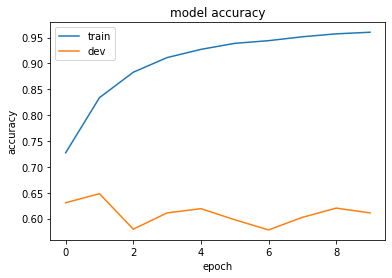

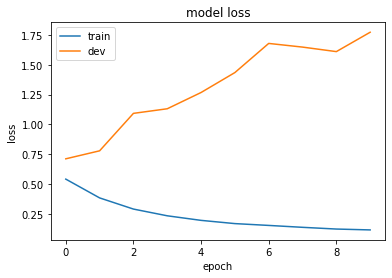

In [49]:
import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [58]:
pd.DataFrame(confusion_matrix(y_test, pred))

,0,1
0,1534,559
1,399,308


In [66]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76      2093
           1       0.36      0.44      0.39       707

    accuracy                           0.66      2800
   macro avg       0.57      0.58      0.58      2800
weighted avg       0.68      0.66      0.67      2800

